In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import sys
sys.path.append("..")

from mechanism.mechanized_models import MechanizedGaussianNB
from mechanism.mechanized_models import MechanizedLogisticRegression
from mechanism.mechanized_models import MechanizedDecisionTree




In [21]:
# Basic preprocessing
def preprocess(df):
    df_new = df.copy()
    
    # Discard identifiers, style information, timestamps
    df_new = df_new[df_new.columns.difference(['image', 'style', 'reviewTime', 
                                               'reviewerID', 'asin', 'reviewerName', 'unixReviewTime'])]

    # Turn category into binary features
    for cat in df_new.category.unique():
        df_new[cat] = df_new['category'] == cat

    # Drop category column
    df_new.drop(columns=['category'], inplace=True)

    # NaN vote is 0 users found helpful
    df_new.vote.fillna(0, inplace=True)
    
    # Turn vote into binary feature
    df_new.vote = df_new.vote > 0
    # df_new.vote.clip(0, 10)
    # df_new.vote = df_new.vote / 10

    # NaN summary is empty summary
    df_new.summary.fillna('', inplace=True)

    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new

In [22]:
# Remove 'overall' column and add cutoff column applying cutoff
def apply_cutoff(df, cutoff):
    df_new = df.copy()
    
    # Apply cutoff
    cut = df['overall'] > cutoff
    df_new['cutoff'] = cut

    # Drop overall and category
    df_new.drop(columns=['overall'], inplace=True)
    
    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new

In [23]:
def apply_tfidf(df, review_vectorizer, summary_vectorizer):
    review_matrix = pd.DataFrame(data=review_vectorizer.transform(df.reviewText).toarray(), columns='R_' + review_vectorizer.get_feature_names_out())
    summary_matrix = pd.DataFrame(data=summary_vectorizer.transform(df.summary).toarray(), columns='S_' + summary_vectorizer.get_feature_names_out())
    df_new = pd.concat([df, review_matrix, summary_matrix], axis=1)
    df_new.drop(columns=['summary', 'reviewText'], inplace=True)
    return df_new

In [24]:
training_df = pd.read_csv('../data/Training.csv')
test_df = pd.read_csv('../data/Test.csv')

#  Processing the data - I

In [25]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 1)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [26]:
X

,verified,vote,automotive,CDs,grocery,cell_phones,sports,toys,R_00,R_000,...,S_zest,S_zest far,S_zest far inferior,S_zimmer,S_zipper,S_zippers,S_zoom,S_zz,S_zz greatest,S_zz greatest hits
0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
relcols

Index(['verified', 'vote', 'R_00', 'R_08', 'R_10 bucks', 'R_12', 'R_15',
       'R_1970', 'R_1970s', 'R_1973',
       ...
       'S_wtf', 'S_year old', 'S_young', 'S_yuck', 'S_yucky', 'S_yuk', 'S_yum',
       'S_yummy', 'S_zero', 'S_zero stars'],
      dtype='object', length=4272)

In [28]:
# We will go with these columns.
X = X[relcols]

In [29]:
# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Mechanized Gaussian Naive Bayesian Inference

In [30]:
# Hyperparameter selection on one split
import sys
sys.path.append("..")

from mechanism.mechanized_models import Mechanism
from mechanism.mechanized_models import MechanizedGridSearchCV
from mechanism.mechanized_models import MechanizedGaussianNB

X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedGaussianNB()
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)
params_GS = {'var_smoothing': np.logspace(-2, -9, num = 2)}
gs_GS = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_GS, cv=3, verbose=3, scoring='f1_macro')
gs_GS.choose_mechanism(Mechanism.GAUSSIAN)
gs_GS.fit(X_train, y_train)
gs_GS.best_params_

in gaussian mechanism GridSearchCV
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END ................var_smoothing=0.01;, score=0.664 total time=   4.9s
[CV 2/3] END ................var_smoothing=0.01;, score=0.694 total time=   3.6s
[CV 3/3] END ................var_smoothing=0.01;, score=0.700 total time=   3.6s
[CV 1/3] END ...............var_smoothing=1e-09;, score=0.662 total time=   3.9s
[CV 2/3] END ...............var_smoothing=1e-09;, score=0.699 total time=   5.5s
[CV 3/3] END ...............var_smoothing=1e-09;, score=0.715 total time=   5.0s


{'var_smoothing': 1e-09}

In [31]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits[:1]):
    print(f"Split {i}:")
    # Train model
    model = MechanizedGaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
    model.choose_mechanism(Mechanism.GAUSSIAN)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedGaussianNB
  F1 score: 0.5968280987611025
  Accuracy: 0.8245974648852347
  ROC/AUC score: 0.8761322058166966
Average F1 score: 0.5968280987611025
Average accuracy: 0.8245974648852347
Average ROC/AUC score: 0.8761322058166966


Text(50.722222222222214, 0.5, 'True label')

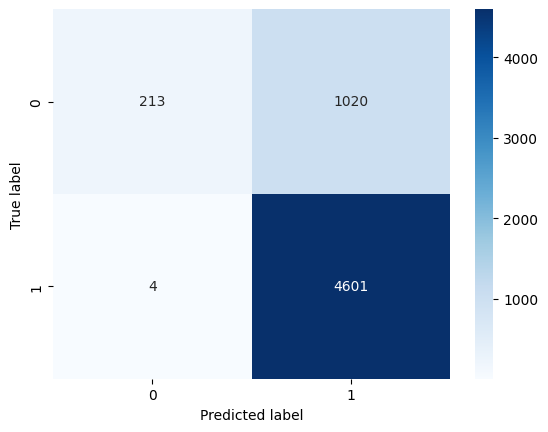

In [32]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

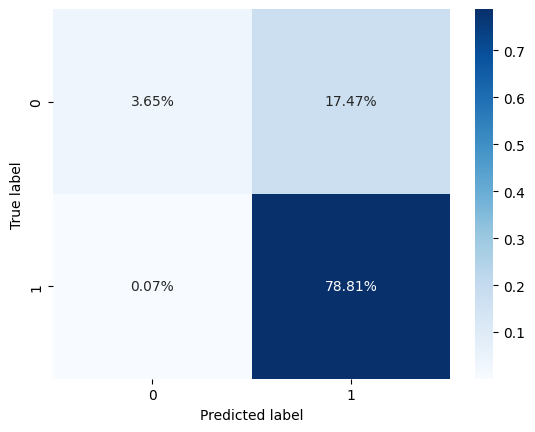

In [33]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [34]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = MechanizedGaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
model.choose_mechanism(Mechanism.GAUSSIAN)
model.fit(X_train, y_train)

in gaussian mechanism MechanizedGaussianNB


MechanizedGaussianNB()

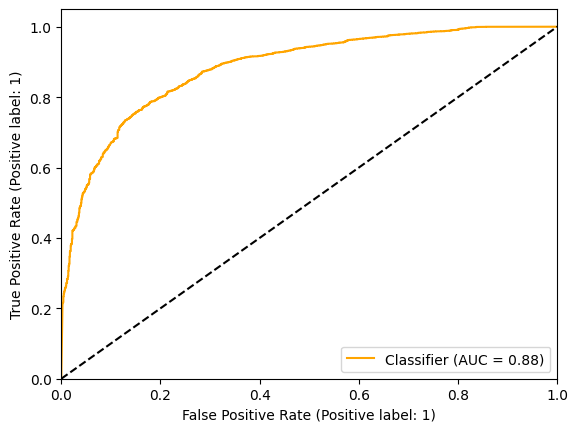

In [35]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

# Processing data - II

In [36]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 2)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Mechanized Gaussian Naive Bayesian Inference

In [37]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedGaussianNB()
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)
params_GS = {'var_smoothing': np.logspace(-2, -9, num = 2)}
gs_GS = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_GS, cv=3, verbose=3, scoring='f1_macro')
gs_GS.choose_mechanism(Mechanism.GAUSSIAN)
gs_GS.fit(X_train, y_train)
gs_GS.best_params_

in gaussian mechanism GridSearchCV
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END ................var_smoothing=0.01;, score=0.656 total time=   3.5s
[CV 2/3] END ................var_smoothing=0.01;, score=0.658 total time=   3.3s
[CV 3/3] END ................var_smoothing=0.01;, score=0.679 total time=   3.4s
[CV 1/3] END ...............var_smoothing=1e-09;, score=0.660 total time=   4.3s
[CV 2/3] END ...............var_smoothing=1e-09;, score=0.677 total time=   3.3s
[CV 3/3] END ...............var_smoothing=1e-09;, score=0.694 total time=   3.2s


{'var_smoothing': 1e-09}

In [38]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits[:1]):
    print(f"Split {i}:")
    # Train model
    model = MechanizedGaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
    model.choose_mechanism(Mechanism.GAUSSIAN)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedGaussianNB
  F1 score: 0.532214905178308
  Accuracy: 0.656731757451182
  ROC/AUC score: 0.837876560374491
Average F1 score: 0.532214905178308
Average accuracy: 0.656731757451182
Average ROC/AUC score: 0.837876560374491


Text(50.722222222222214, 0.5, 'True label')

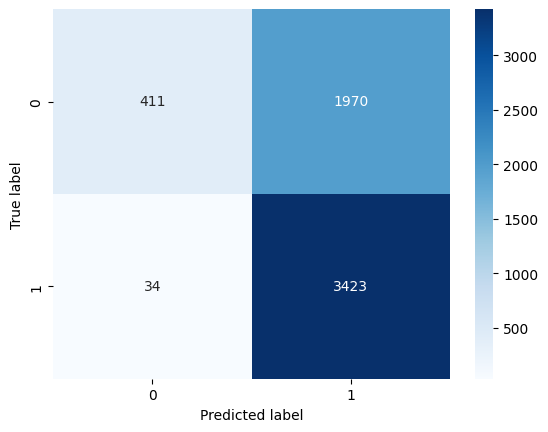

In [39]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

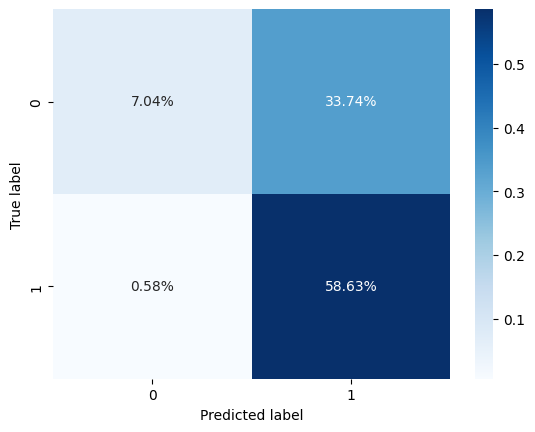

In [40]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [41]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = MechanizedGaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
model.choose_mechanism(Mechanism.GAUSSIAN)
model.fit(X_train, y_train)

in gaussian mechanism MechanizedGaussianNB


MechanizedGaussianNB()

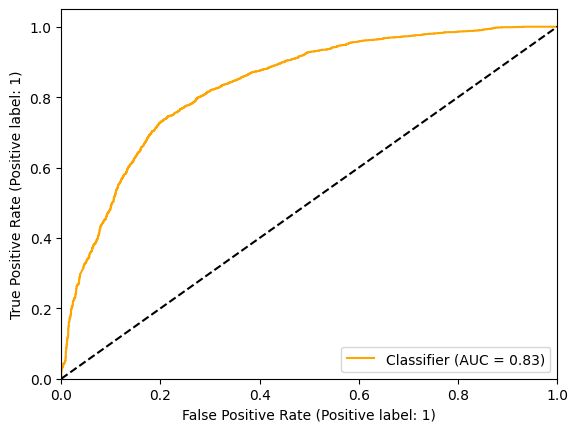

In [42]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

# Processing the data - III

In [43]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 3)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Mechanized Gaussian Naive Bayesian Inference

In [44]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedGaussianNB()
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)
params_GS = {'var_smoothing': np.logspace(-2, -9, num=2)}
gs_GS = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_GS, cv=3, verbose=3, scoring='f1_macro')
gs_GS.choose_mechanism(Mechanism.GAUSSIAN)
gs_GS.fit(X_train, y_train)
gs_GS.best_params_

in gaussian mechanism GridSearchCV
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END ................var_smoothing=0.01;, score=0.646 total time=   4.9s
[CV 2/3] END ................var_smoothing=0.01;, score=0.651 total time=   4.4s
[CV 3/3] END ................var_smoothing=0.01;, score=0.666 total time=   4.2s
[CV 1/3] END ...............var_smoothing=1e-09;, score=0.643 total time=   4.1s
[CV 2/3] END ...............var_smoothing=1e-09;, score=0.655 total time=   4.0s
[CV 3/3] END ...............var_smoothing=1e-09;, score=0.665 total time=   4.1s


{'var_smoothing': 1e-09}

In [45]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits[:1]):
    print(f"Split {i}:")
    # Train model
    model = MechanizedGaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
    model.choose_mechanism(Mechanism.GAUSSIAN)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedGaussianNB
  F1 score: 0.751239006197821
  Accuracy: 0.7697841726618705
  ROC/AUC score: 0.8448567619477132
Average F1 score: 0.751239006197821
Average accuracy: 0.7697841726618705
Average ROC/AUC score: 0.8448567619477132


Text(50.722222222222214, 0.5, 'True label')

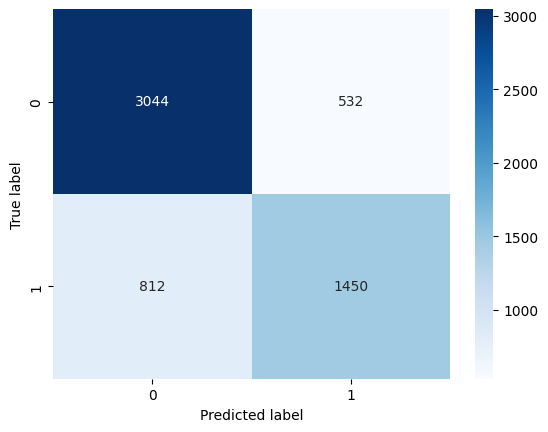

In [46]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

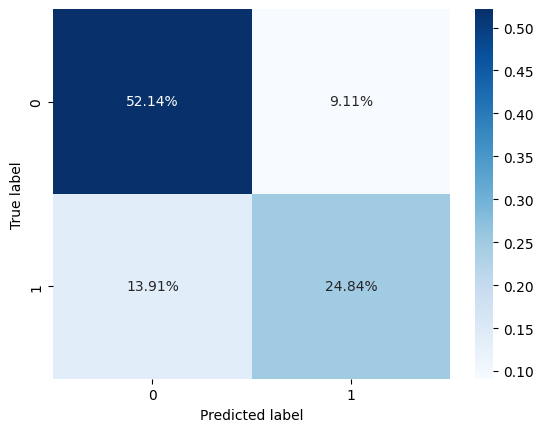

In [47]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [48]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = MechanizedGaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
model.choose_mechanism(Mechanism.GAUSSIAN)
model.fit(X_train, y_train)

in gaussian mechanism MechanizedGaussianNB


MechanizedGaussianNB()

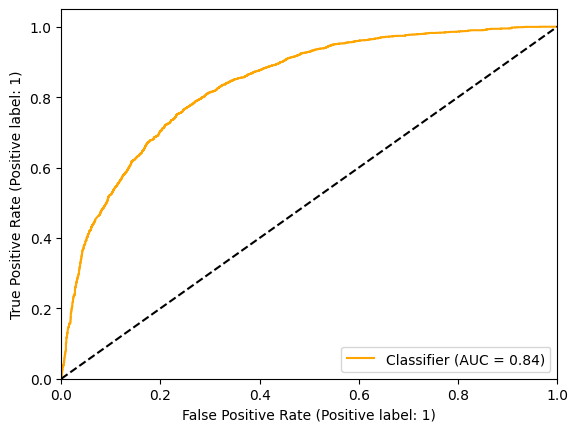

In [49]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

# Processing the data - IV

In [50]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 4)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Mechanized Gaussian Naive Bayesian Inference

In [51]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedGaussianNB()
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)
params_GS = {'var_smoothing': np.logspace(-2, -9, num = 2)}
gs_GS = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_GS, cv=3, verbose=3, scoring='f1_macro')
gs_GS.choose_mechanism(Mechanism.GAUSSIAN)
gs_GS.fit(X_train, y_train)
gs_GS.best_params_

in gaussian mechanism GridSearchCV
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END ................var_smoothing=0.01;, score=0.627 total time=   3.2s
[CV 2/3] END ................var_smoothing=0.01;, score=0.647 total time=   2.9s
[CV 3/3] END ................var_smoothing=0.01;, score=0.646 total time=   2.8s
[CV 1/3] END ...............var_smoothing=1e-09;, score=0.632 total time=   2.9s
[CV 2/3] END ...............var_smoothing=1e-09;, score=0.643 total time=   2.9s
[CV 3/3] END ...............var_smoothing=1e-09;, score=0.644 total time=   2.9s


{'var_smoothing': 0.01}

In [52]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits[:1]):
    print(f"Split {i}:")
    # Train model
    model = MechanizedGaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
    model.choose_mechanism(Mechanism.GAUSSIAN)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedGaussianNB
  F1 score: 0.6711784753605206
  Accuracy: 0.8326481671805412
  ROC/AUC score: 0.8293654850664023
Average F1 score: 0.6711784753605206
Average accuracy: 0.8326481671805412
Average ROC/AUC score: 0.8293654850664023


Text(50.722222222222214, 0.5, 'True label')

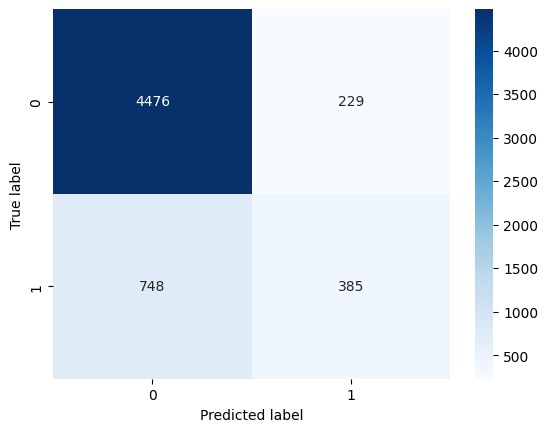

In [53]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

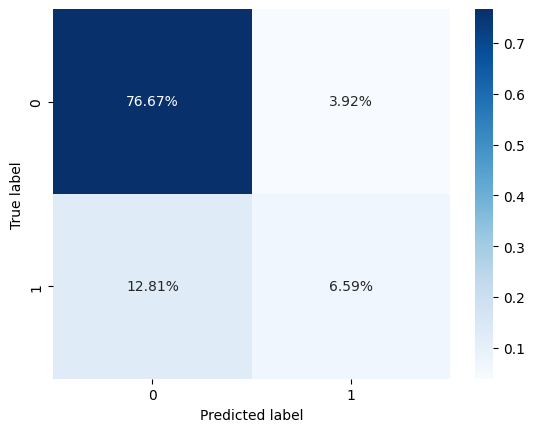

In [54]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [55]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = MechanizedGaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
model.choose_mechanism(Mechanism.GAUSSIAN)
model.fit(X_train, y_train)

in gaussian mechanism MechanizedGaussianNB


MechanizedGaussianNB(var_smoothing=0.01)

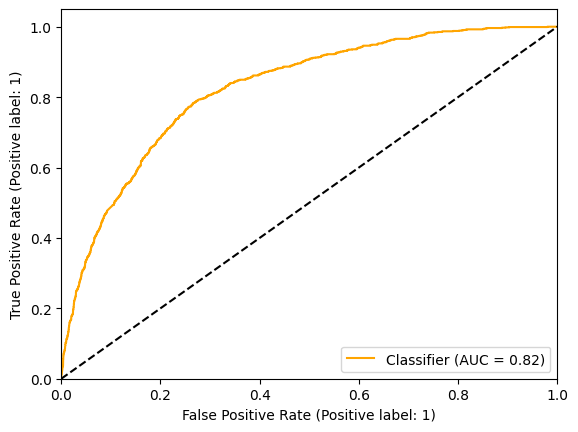

In [56]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')